## Assignment 4 - Understanding and Predicting Property Maintenance Fines

This assignment is based on a data challenge from the Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)). 

The Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)) and the Michigan Student Symposium for Interdisciplinary Statistical Sciences ([MSSISS](https://sites.lsa.umich.edu/mssiss/)) have partnered with the City of Detroit to help solve one of the most pressing problems facing Detroit - blight. [Blight violations](http://www.detroitmi.gov/How-Do-I/Report/Blight-Complaint-FAQs) are issued by the city to individuals who allow their properties to remain in a deteriorated condition. Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: how can we increase blight ticket compliance?

The first step in answering this question is understanding when and why a resident might fail to comply with a blight ticket. This is where predictive modeling comes in. For this assignment, your task is to predict whether a given blight ticket will be paid on time.

All data for this assignment has been provided to us through the [Detroit Open Data Portal](https://data.detroitmi.gov/). **Only the data already included in your Coursera directory can be used for training the model for this assignment.** Nonetheless, we encourage you to look into data from other Detroit datasets to help inform feature creation and model selection. We recommend taking a look at the following related datasets:

* [Building Permits](https://data.detroitmi.gov/Property-Parcels/Building-Permits/xw2a-a7tf)
* [Trades Permits](https://data.detroitmi.gov/Property-Parcels/Trades-Permits/635b-dsgv)
* [Improve Detroit: Submitted Issues](https://data.detroitmi.gov/Government/Improve-Detroit-Submitted-Issues/fwz3-w3yn)
* [DPD: Citizen Complaints](https://data.detroitmi.gov/Public-Safety/DPD-Citizen-Complaints-2016/kahe-efs3)
* [Parcel Map](https://data.detroitmi.gov/Property-Parcels/Parcel-Map/fxkw-udwf)

___

We provide you with two data files for use in training and validating your models: train.csv and test.csv. Each row in these two files corresponds to a single blight ticket, and includes information about when, why, and to whom each ticket was issued. The target variable is compliance, which is True if the ticket was paid early, on time, or within one month of the hearing data, False if the ticket was paid after the hearing date or not at all, and Null if the violator was found not responsible. Compliance, as well as a handful of other variables that will not be available at test-time, are only included in train.csv.

Note: All tickets where the violators were found not responsible are not considered during evaluation. They are included in the training set as an additional source of data for visualization, and to enable unsupervised and semi-supervised approaches. However, they are not included in the test set.

<br>

**File descriptions** (Use only this data for training your model!)

    readonly/train.csv - the training set (all tickets issued 2004-2011)
    readonly/test.csv - the test set (all tickets issued 2012-2016)
    readonly/addresses.csv & readonly/latlons.csv - mapping from ticket id to addresses, and from addresses to lat/lon coordinates. 
     Note: misspelled addresses may be incorrectly geolocated.

<br>

**Data fields**

train.csv & test.csv

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    
train.csv only

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction] 
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant


___

## Evaluation

Your predictions will be given as the probability that the corresponding blight ticket will be paid on time.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC). 

Your grade will be based on the AUC score computed for your classifier. A model which with an AUROC of 0.7 passes this assignment, over 0.75 will recieve full points.
___

For this assignment, create a function that trains a model to predict blight ticket compliance in Detroit using `readonly/train.csv`. Using this model, return a series of length 61001 with the data being the probability that each corresponding ticket from `readonly/test.csv` will be paid, and the index being the ticket_id.

Example:

    ticket_id
       284932    0.531842
       285362    0.401958
       285361    0.105928
       285338    0.018572
                 ...
       376499    0.208567
       376500    0.818759
       369851    0.018528
       Name: compliance, dtype: float32
       
### Hints

* Make sure your code is working before submitting it to the autograder.

* Print out your result to see whether there is anything weird (e.g., all probabilities are the same).

* Generally the total runtime should be less than 10 mins. You should NOT use Neural Network related classifiers (e.g., MLPClassifier) in this question. 

* Try to avoid global variables. If you have other functions besides blight_model, you should move those functions inside the scope of blight_model.

* Refer to the pinned threads in Week 4's discussion forum when there is something you could not figure it out.

In [241]:
import pandas as pd
import numpy as np
from pandas import read_csv
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from matplotlib import pyplot
from datetime import datetime

## 1.  Load data

In [142]:
adr = read_csv('readonly/addresses.csv')
adr

,ticket_id,address
0,22056,"2900 tyler, Detroit MI"
1,27586,"4311 central, Detroit MI"
2,22062,"1449 longfellow, Detroit MI"
3,22084,"1441 longfellow, Detroit MI"
4,22093,"2449 churchill, Detroit MI"
...,...,...
311302,376496,"12032 santa rosa, Detroit MI 48204"
311303,376497,"12032 santa rosa, Detroit MI 48204"
311304,376499,"11832 kilbourne, Detroit MI 48213"
311305,376500,"11848 kilbourne, Detroit MI 48213"


In [143]:
latlons = read_csv('readonly/latlons.csv')
latlons

,address,lat,lon
0,"4300 rosa parks blvd, Detroit MI 48208",42.346169,-83.079962
1,"14512 sussex, Detroit MI",42.394657,-83.194265
2,"3456 garland, Detroit MI",42.373779,-82.986228
3,"5787 wayburn, Detroit MI",42.403342,-82.957805
4,"5766 haverhill, Detroit MI",42.407255,-82.946295
...,...,...,...
121764,"14267 sorrento, Detroit MI",42.392339,-83.172412
121765,"9359 vaughan, Detroit MI",42.363781,-83.237494
121766,"5911 courville, Detroit MI",42.409321,-82.943282
121767,"14545 wyoming, Detroit MI",42.395836,-83.159670


In [144]:
df = pd.read_csv('train.csv',encoding='cp1252')
df

/var/folders/96/6jf045t109g4mzwn7_3s3lz80000gn/T/ipykernel_75864/3639834987.py:1: DtypeWarning: Columns (11,12,31) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('train.csv',encoding='cp1252')


,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,clean_up_cost,judgment_amount,payment_amount,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance
0,22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900.0,TYLER,NaN,3.0,S. WICKER,CHICAGO,...,0.0,305.0,0.0,305.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0
1,27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311.0,CENTRAL,NaN,2959.0,Martin Luther King,Detroit,...,0.0,855.0,780.0,75.0,2005-06-02 00:00:00,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0
2,22062,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","SANDERS, DERRON",1449.0,LONGFELLOW,NaN,23658.0,P.O. BOX,DETROIT,...,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN
3,22084,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","MOROSI, MIKE",1441.0,LONGFELLOW,NaN,5.0,ST. CLAIR,DETROIT,...,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN
4,22093,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","NATHANIEL, NEAL",2449.0,CHURCHILL,NaN,7449.0,CHURCHILL,DETROIT,...,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250301,325555,"Buildings, Safety Engineering & Env Department","Bush, Wesley",WESTGATE TERRACE APARTMENTS LLC,10701.0,SANTA MARIA,NaN,1715.0,MEYERS,DETROIT,...,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN
250302,325557,"Buildings, Safety Engineering & Env Department","Bush, Wesley",WESTGATE TERRACE APARTMENTS LLC,10701.0,MEYERS RD,NaN,1715.0,MEYERS,DETROIT,...,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN
250303,325562,"Buildings, Safety Engineering & Env Department","Bush, Wesley",WESTGATE TERRACE APARTMENTS LLC,10701.0,MEYERS RD,NaN,1715.0,MEYERS,DETROIT,...,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN
250304,325559,"Buildings, Safety Engineering & Env Department","Bush, Wesley",WESTGATE TERRACE APARTMENTS LLC,10701.0,MEYERS RD,NaN,1715.0,MEYERS,DETROIT,...,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN


In [145]:
nona = df.dropna(axis=1)
nona.columns

Index(['ticket_id', 'agency_name', 'inspector_name', 'violation_street_number',
       'violation_street_name', 'city', 'country', 'ticket_issued_date',
       'violation_code', 'violation_description', 'disposition', 'admin_fee',
       'state_fee', 'late_fee', 'discount_amount', 'clean_up_cost',
       'judgment_amount', 'payment_amount', 'balance_due', 'payment_status',
       'compliance_detail'],
      dtype='object')

In [146]:
# getting columns
df.columns

Index(['ticket_id', 'agency_name', 'inspector_name', 'violator_name',
       'violation_street_number', 'violation_street_name',
       'violation_zip_code', 'mailing_address_str_number',
       'mailing_address_str_name', 'city', 'state', 'zip_code',
       'non_us_str_code', 'country', 'ticket_issued_date', 'hearing_date',
       'violation_code', 'violation_description', 'disposition', 'fine_amount',
       'admin_fee', 'state_fee', 'late_fee', 'discount_amount',
       'clean_up_cost', 'judgment_amount', 'payment_amount', 'balance_due',
       'payment_date', 'payment_status', 'collection_status',
       'grafitti_status', 'compliance_detail', 'compliance'],
      dtype='object')

In [147]:
# repeat everything for test set
df2 = pd.read_csv('readonly/test.csv')

### 1.1 Summary of columns

In [148]:
df.describe()

,ticket_id,violation_street_number,violation_zip_code,mailing_address_str_number,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,payment_amount,balance_due,compliance
count,250306.000000,2.503060e+05,0.0,2.467040e+05,250305.000000,250306.000000,250306.000000,250306.000000,250306.000000,250306.0,250306.000000,250306.000000,250306.000000,159880.000000
mean,152665.543099,1.064986e+04,NaN,9.149788e+03,374.423435,12.774764,6.387382,21.494506,0.125167,0.0,268.685356,48.898986,222.449058,0.072536
std,77189.882881,3.188733e+04,NaN,3.602034e+04,707.195807,9.607344,4.803672,56.464263,3.430178,0.0,626.915212,222.422425,606.394010,0.259374
min,18645.000000,0.000000e+00,NaN,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,-7750.000000,0.000000
25%,86549.250000,4.739000e+03,NaN,5.440000e+02,200.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,152597.500000,1.024400e+04,NaN,2.456000e+03,250.000000,20.000000,10.000000,10.000000,0.000000,0.0,140.000000,0.000000,25.000000,0.000000
75%,219888.750000,1.576000e+04,NaN,1.292725e+04,250.000000,20.000000,10.000000,25.000000,0.000000,0.0,305.000000,0.000000,305.000000,0.000000
max,366178.000000,1.415411e+07,NaN,5.111345e+06,10000.000000,20.000000,10.000000,1000.000000,350.000000,0.0,11030.000000,11075.000000,11030.000000,1.000000


### Delete nan value columns to get rid of useless columns

In [149]:
df2

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,violation_description,disposition,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,grafitti_status
0,284932,Department of Public Works,"Granberry, Aisha B","FLUELLEN, JOHN A",10041.0,ROSEBERRY,NaN,141,ROSEBERRY,DETROIT,...,Failure to secure City or Private solid waste ...,Responsible by Default,200.0,20.0,10.0,20.0,0.0,0.0,250.0,NaN
1,285362,Department of Public Works,"Lusk, Gertrina","WHIGHAM, THELMA",18520.0,EVERGREEN,NaN,19136,GLASTONBURY,DETROIT,...,Allowing bulk solid waste to lie or accumulate...,Responsible by Default,1000.0,20.0,10.0,100.0,0.0,0.0,1130.0,NaN
2,285361,Department of Public Works,"Lusk, Gertrina","WHIGHAM, THELMA",18520.0,EVERGREEN,NaN,19136,GLASTONBURY,DETROIT,...,Improper placement of Courville container betw...,Responsible by Default,100.0,20.0,10.0,10.0,0.0,0.0,140.0,NaN
3,285338,Department of Public Works,"Talbert, Reginald","HARABEDIEN, POPKIN",1835.0,CENTRAL,NaN,2246,NELSON,WOODHAVEN,...,Allowing bulk solid waste to lie or accumulate...,Responsible by Default,200.0,20.0,10.0,20.0,0.0,0.0,250.0,NaN
4,285346,Department of Public Works,"Talbert, Reginald","CORBELL, STANLEY",1700.0,CENTRAL,NaN,3435,MUNGER,LIVONIA,...,Violation of time limit for approved container...,Responsible by Default,100.0,20.0,10.0,10.0,0.0,0.0,140.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60996,376496,"Buildings, Safety Engineering & Env Department","Pierson, Kevin",THE AIC GROUP,12032.0,SANTA ROSA,48204,P.O. BO,969,Southfield,...,Fail to comply with an Emergency or imminent d...,Responsible by Default,1000.0,20.0,10.0,100.0,0.0,0.0,1130.0,NaN
60997,376497,"Buildings, Safety Engineering & Env Department","Pierson, Kevin",THE AIC GROUP,12032.0,SANTA ROSA,48204,P.O. BO,969,Southfield,...,Fail to comply with an Emergency or imminent d...,Responsible by Default,1000.0,20.0,10.0,100.0,0.0,0.0,1130.0,NaN
60998,376499,Detroit Police Department,"BOWLES, TIFFANI","BARLOW, CHRISTOPHER D",11832.0,KILBOURNE,48213,11832,KILBOURNE,DETROIT,...,Violation of time limit for approved container...,Responsible by Default,100.0,20.0,10.0,10.0,0.0,0.0,140.0,NaN
60999,376500,Detroit Police Department,"BOWLES, TIFFANI","WILLIAMS, JASON",11848.0,KILBOURNE,48213,4317,YORKSHIRE,DETROIT,...,Violation of time limit for approved container...,Responsible by Default,100.0,20.0,10.0,10.0,0.0,0.0,140.0,NaN


In [150]:
X_test = df2
X_test

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,violation_description,disposition,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,grafitti_status
0,284932,Department of Public Works,"Granberry, Aisha B","FLUELLEN, JOHN A",10041.0,ROSEBERRY,NaN,141,ROSEBERRY,DETROIT,...,Failure to secure City or Private solid waste ...,Responsible by Default,200.0,20.0,10.0,20.0,0.0,0.0,250.0,NaN
1,285362,Department of Public Works,"Lusk, Gertrina","WHIGHAM, THELMA",18520.0,EVERGREEN,NaN,19136,GLASTONBURY,DETROIT,...,Allowing bulk solid waste to lie or accumulate...,Responsible by Default,1000.0,20.0,10.0,100.0,0.0,0.0,1130.0,NaN
2,285361,Department of Public Works,"Lusk, Gertrina","WHIGHAM, THELMA",18520.0,EVERGREEN,NaN,19136,GLASTONBURY,DETROIT,...,Improper placement of Courville container betw...,Responsible by Default,100.0,20.0,10.0,10.0,0.0,0.0,140.0,NaN
3,285338,Department of Public Works,"Talbert, Reginald","HARABEDIEN, POPKIN",1835.0,CENTRAL,NaN,2246,NELSON,WOODHAVEN,...,Allowing bulk solid waste to lie or accumulate...,Responsible by Default,200.0,20.0,10.0,20.0,0.0,0.0,250.0,NaN
4,285346,Department of Public Works,"Talbert, Reginald","CORBELL, STANLEY",1700.0,CENTRAL,NaN,3435,MUNGER,LIVONIA,...,Violation of time limit for approved container...,Responsible by Default,100.0,20.0,10.0,10.0,0.0,0.0,140.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60996,376496,"Buildings, Safety Engineering & Env Department","Pierson, Kevin",THE AIC GROUP,12032.0,SANTA ROSA,48204,P.O. BO,969,Southfield,...,Fail to comply with an Emergency or imminent d...,Responsible by Default,1000.0,20.0,10.0,100.0,0.0,0.0,1130.0,NaN
60997,376497,"Buildings, Safety Engineering & Env Department","Pierson, Kevin",THE AIC GROUP,12032.0,SANTA ROSA,48204,P.O. BO,969,Southfield,...,Fail to comply with an Emergency or imminent d...,Responsible by Default,1000.0,20.0,10.0,100.0,0.0,0.0,1130.0,NaN
60998,376499,Detroit Police Department,"BOWLES, TIFFANI","BARLOW, CHRISTOPHER D",11832.0,KILBOURNE,48213,11832,KILBOURNE,DETROIT,...,Violation of time limit for approved container...,Responsible by Default,100.0,20.0,10.0,10.0,0.0,0.0,140.0,NaN
60999,376500,Detroit Police Department,"BOWLES, TIFFANI","WILLIAMS, JASON",11848.0,KILBOURNE,48213,4317,YORKSHIRE,DETROIT,...,Violation of time limit for approved container...,Responsible by Default,100.0,20.0,10.0,10.0,0.0,0.0,140.0,NaN


In [151]:
# load the dataset
# col_list_str - second variable
def load_dataset(filename):
    # load the dataset as a pandas DataFrame
    # dropped header=None
    #data = read_csv(filename, encoding='cp1252', low_memory=False)
    # retrieve numpy array
    #dataset = data.values
    dataset = filename
    dataset = dataset[dataset['compliance'].notna()]
    dataset = dataset[dataset['hearing_date'].notna()]
    dataset = dataset[dataset['payment_date'].notna()]
    #dataset = dataset.dropna(axis='columns')
    
    # split into input (X) and output (y) variables
    #X_train = dataset.iloc[:, :-1]
    #y_train = dataset.iloc[:,-1]
    '''for col_name in col_list_str :
        X[col_name] = X[col_name].astype(str)'''
    # format all fields as string

    return dataset

# load the dataset
dataset = load_dataset(df)

In [152]:
dataset

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,clean_up_cost,judgment_amount,payment_amount,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance
1,27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311.0,CENTRAL,NaN,2959.0,Martin Luther King,Detroit,...,0.0,855.0,780.0,75.0,2005-06-02 00:00:00,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0
18,18746,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Klenk, Dean",14715.0,KLENK,NaN,14715.0,Klenk,Detroit,...,0.0,140.0,130.0,10.0,2005-03-18 00:00:00,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0
19,18744,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Kuhn, Dean",14715.0,KLENK,NaN,141715.0,Klenk,Detroit,...,0.0,140.0,130.0,10.0,2005-03-18 00:00:00,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0
26,19950,Health Department,"Jones, Leah","CHURCH OF GOD, METROPOLITAN",13400.0,SCHAEFER,NaN,134.0,SCHAFER,DETROIT,...,0.0,130.0,120.0,10.0,2010-01-26 00:00:00,PARTIAL PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0
33,18664,"Buildings, Safety Engineering & Env Department","Schuman, Randy","FREEDMAN, PAUL",343.0,MACOMB,NaN,4541.0,STONEVIEW,W.BLOOMFIELD,...,0.0,305.0,305.0,0.0,2007-05-31 00:00:00,PAID IN FULL,NaN,NaN,non-compliant by late payment more than 1 month,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250215,285022,Department of Public Works,"Williamson, Lillett","VILAS HOLDING CORP.,",11560.0,HARPER,NaN,1156.0,HARPER,DETROIT,...,0.0,230.0,210.0,20.0,2012-01-23 00:00:00,PARTIAL PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0
250232,267968,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","Isseru, James",12101.0,GRAND RIVER,NaN,1211.0,W. Grand River,Detroit,...,0.0,280.0,255.0,25.0,2011-03-01 00:00:00,PARTIAL PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0
250249,267964,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","Farhar, Mark",20121.0,SCHOOLCRAFT,NaN,7755.0,Freda,Dearborn,...,0.0,305.0,305.0,0.0,2016-10-25 00:00:00,PAID IN FULL,NaN,NaN,non-compliant by late payment more than 1 month,0.0
250250,267966,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","Tionnon, Lenell",9960.0,FREELAND,NaN,18622.0,Hessell,Detroit,...,0.0,280.0,255.0,25.0,2011-03-02 00:00:00,PARTIAL PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0


In [153]:
# vet each column of df
list(dataset.columns)

['ticket_id',
 'agency_name',
 'inspector_name',
 'violator_name',
 'violation_street_number',
 'violation_street_name',
 'violation_zip_code',
 'mailing_address_str_number',
 'mailing_address_str_name',
 'city',
 'state',
 'zip_code',
 'non_us_str_code',
 'country',
 'ticket_issued_date',
 'hearing_date',
 'violation_code',
 'violation_description',
 'disposition',
 'fine_amount',
 'admin_fee',
 'state_fee',
 'late_fee',
 'discount_amount',
 'clean_up_cost',
 'judgment_amount',
 'payment_amount',
 'balance_due',
 'payment_date',
 'payment_status',
 'collection_status',
 'grafitti_status',
 'compliance_detail',
 'compliance']

In [154]:
# finding type of hearing_date
type(dataset.hearing_date[1])

str

In [155]:
dataset.hearing_date[1]

'2005-05-06 13:30:00'

In [156]:
from datetime import datetime

date_time_obj = datetime.strptime(dataset.hearing_date[1], '%Y-%m-%d %H:%M:%S')


print ("The type of the date is now",  type(date_time_obj))
print ("The date is", date_time_obj)

The type of the date is now <class 'datetime.datetime'>
The date is 2005-05-06 13:30:00


In [157]:
dataset.hearing_date = dataset['hearing_date'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
dataset.payment_date = dataset['payment_date'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))

In [158]:
dataset.hearing_date

1        2005-05-06 13:30:00
18       2005-02-22 15:00:00
19       2005-02-22 15:00:00
26       2005-02-10 15:00:00
33       2005-03-23 15:00:00
                 ...        
250215   2012-01-23 15:00:00
250232   2011-03-01 15:00:00
250249   2011-05-12 15:00:00
250250   2011-03-02 15:00:00
250290   2012-02-07 13:30:00
Name: hearing_date, Length: 39439, dtype: datetime64[ns]

In [159]:
dataset.payment_date

1        2005-06-02
18       2005-03-18
19       2005-03-18
26       2010-01-26
33       2007-05-31
            ...    
250215   2012-01-23
250232   2011-03-01
250249   2016-10-25
250250   2011-03-02
250290   2012-02-07
Name: payment_date, Length: 39439, dtype: datetime64[ns]

In [160]:
dataset['diff'] = dataset.payment_date - dataset.hearing_date
dataset

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,judgment_amount,payment_amount,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance,diff
1,27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311.0,CENTRAL,NaN,2959.0,Martin Luther King,Detroit,...,855.0,780.0,75.0,2005-06-02,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0,26 days 10:30:00
18,18746,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Klenk, Dean",14715.0,KLENK,NaN,14715.0,Klenk,Detroit,...,140.0,130.0,10.0,2005-03-18,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0,23 days 09:00:00
19,18744,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Kuhn, Dean",14715.0,KLENK,NaN,141715.0,Klenk,Detroit,...,140.0,130.0,10.0,2005-03-18,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0,23 days 09:00:00
26,19950,Health Department,"Jones, Leah","CHURCH OF GOD, METROPOLITAN",13400.0,SCHAEFER,NaN,134.0,SCHAFER,DETROIT,...,130.0,120.0,10.0,2010-01-26,PARTIAL PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0,1810 days 09:00:00
33,18664,"Buildings, Safety Engineering & Env Department","Schuman, Randy","FREEDMAN, PAUL",343.0,MACOMB,NaN,4541.0,STONEVIEW,W.BLOOMFIELD,...,305.0,305.0,0.0,2007-05-31,PAID IN FULL,NaN,NaN,non-compliant by late payment more than 1 month,0.0,798 days 09:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250215,285022,Department of Public Works,"Williamson, Lillett","VILAS HOLDING CORP.,",11560.0,HARPER,NaN,1156.0,HARPER,DETROIT,...,230.0,210.0,20.0,2012-01-23,PARTIAL PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0,-1 days +09:00:00
250232,267968,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","Isseru, James",12101.0,GRAND RIVER,NaN,1211.0,W. Grand River,Detroit,...,280.0,255.0,25.0,2011-03-01,PARTIAL PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0,-1 days +09:00:00
250249,267964,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","Farhar, Mark",20121.0,SCHOOLCRAFT,NaN,7755.0,Freda,Dearborn,...,305.0,305.0,0.0,2016-10-25,PAID IN FULL,NaN,NaN,non-compliant by late payment more than 1 month,0.0,1992 days 09:00:00
250250,267966,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","Tionnon, Lenell",9960.0,FREELAND,NaN,18622.0,Hessell,Detroit,...,280.0,255.0,25.0,2011-03-02,PARTIAL PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0,-1 days +09:00:00


In [161]:
column_to_move = dataset.pop("diff")

# insert column with insert(location, column_name, column_value)

dataset.insert(1, "diff", column_to_move)

dataset

,ticket_id,diff,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,...,clean_up_cost,judgment_amount,payment_amount,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance
1,27586,26 days 10:30:00,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311.0,CENTRAL,NaN,2959.0,Martin Luther King,...,0.0,855.0,780.0,75.0,2005-06-02,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0
18,18746,23 days 09:00:00,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Klenk, Dean",14715.0,KLENK,NaN,14715.0,Klenk,...,0.0,140.0,130.0,10.0,2005-03-18,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0
19,18744,23 days 09:00:00,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Kuhn, Dean",14715.0,KLENK,NaN,141715.0,Klenk,...,0.0,140.0,130.0,10.0,2005-03-18,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0
26,19950,1810 days 09:00:00,Health Department,"Jones, Leah","CHURCH OF GOD, METROPOLITAN",13400.0,SCHAEFER,NaN,134.0,SCHAFER,...,0.0,130.0,120.0,10.0,2010-01-26,PARTIAL PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0
33,18664,798 days 09:00:00,"Buildings, Safety Engineering & Env Department","Schuman, Randy","FREEDMAN, PAUL",343.0,MACOMB,NaN,4541.0,STONEVIEW,...,0.0,305.0,305.0,0.0,2007-05-31,PAID IN FULL,NaN,NaN,non-compliant by late payment more than 1 month,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250215,285022,-1 days +09:00:00,Department of Public Works,"Williamson, Lillett","VILAS HOLDING CORP.,",11560.0,HARPER,NaN,1156.0,HARPER,...,0.0,230.0,210.0,20.0,2012-01-23,PARTIAL PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0
250232,267968,-1 days +09:00:00,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","Isseru, James",12101.0,GRAND RIVER,NaN,1211.0,W. Grand River,...,0.0,280.0,255.0,25.0,2011-03-01,PARTIAL PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0
250249,267964,1992 days 09:00:00,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","Farhar, Mark",20121.0,SCHOOLCRAFT,NaN,7755.0,Freda,...,0.0,305.0,305.0,0.0,2016-10-25,PAID IN FULL,NaN,NaN,non-compliant by late payment more than 1 month,0.0
250250,267966,-1 days +09:00:00,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","Tionnon, Lenell",9960.0,FREELAND,NaN,18622.0,Hessell,...,0.0,280.0,255.0,25.0,2011-03-02,PARTIAL PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0


In [162]:
dataset.reset_index(drop=True)

,ticket_id,diff,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,...,clean_up_cost,judgment_amount,payment_amount,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance
0,27586,26 days 10:30:00,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311.0,CENTRAL,NaN,2959.0,Martin Luther King,...,0.0,855.0,780.0,75.0,2005-06-02,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0
1,18746,23 days 09:00:00,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Klenk, Dean",14715.0,KLENK,NaN,14715.0,Klenk,...,0.0,140.0,130.0,10.0,2005-03-18,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0
2,18744,23 days 09:00:00,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Kuhn, Dean",14715.0,KLENK,NaN,141715.0,Klenk,...,0.0,140.0,130.0,10.0,2005-03-18,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0
3,19950,1810 days 09:00:00,Health Department,"Jones, Leah","CHURCH OF GOD, METROPOLITAN",13400.0,SCHAEFER,NaN,134.0,SCHAFER,...,0.0,130.0,120.0,10.0,2010-01-26,PARTIAL PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0
4,18664,798 days 09:00:00,"Buildings, Safety Engineering & Env Department","Schuman, Randy","FREEDMAN, PAUL",343.0,MACOMB,NaN,4541.0,STONEVIEW,...,0.0,305.0,305.0,0.0,2007-05-31,PAID IN FULL,NaN,NaN,non-compliant by late payment more than 1 month,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39434,285022,-1 days +09:00:00,Department of Public Works,"Williamson, Lillett","VILAS HOLDING CORP.,",11560.0,HARPER,NaN,1156.0,HARPER,...,0.0,230.0,210.0,20.0,2012-01-23,PARTIAL PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0
39435,267968,-1 days +09:00:00,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","Isseru, James",12101.0,GRAND RIVER,NaN,1211.0,W. Grand River,...,0.0,280.0,255.0,25.0,2011-03-01,PARTIAL PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0
39436,267964,1992 days 09:00:00,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","Farhar, Mark",20121.0,SCHOOLCRAFT,NaN,7755.0,Freda,...,0.0,305.0,305.0,0.0,2016-10-25,PAID IN FULL,NaN,NaN,non-compliant by late payment more than 1 month,0.0
39437,267966,-1 days +09:00:00,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","Tionnon, Lenell",9960.0,FREELAND,NaN,18622.0,Hessell,...,0.0,280.0,255.0,25.0,2011-03-02,PARTIAL PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0


In [163]:
# only keep 'Detroit' or 'DETROIT'
dataset['city']

1              Detroit
18             Detroit
19             Detroit
26             DETROIT
33        W.BLOOMFIELD
              ...     
250215         DETROIT
250232         Detroit
250249        Dearborn
250250         Detroit
250290         DETROIT
Name: city, Length: 39439, dtype: object

In [164]:
dataset = dataset[dataset['city'].str.contains('Detroit|DETROIT')]
dataset = dataset.reset_index(drop=True)
dataset

,ticket_id,diff,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,...,clean_up_cost,judgment_amount,payment_amount,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance
0,27586,26 days 10:30:00,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311.0,CENTRAL,NaN,2959.0,Martin Luther King,...,0.0,855.0,780.0,75.0,2005-06-02,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0
1,18746,23 days 09:00:00,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Klenk, Dean",14715.0,KLENK,NaN,14715.0,Klenk,...,0.0,140.0,130.0,10.0,2005-03-18,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0
2,18744,23 days 09:00:00,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Kuhn, Dean",14715.0,KLENK,NaN,141715.0,Klenk,...,0.0,140.0,130.0,10.0,2005-03-18,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0
3,19950,1810 days 09:00:00,Health Department,"Jones, Leah","CHURCH OF GOD, METROPOLITAN",13400.0,SCHAEFER,NaN,134.0,SCHAFER,...,0.0,130.0,120.0,10.0,2010-01-26,PARTIAL PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0
4,18657,18 days 09:00:00,"Buildings, Safety Engineering & Env Department","Schuman, Randy",", APB LAUNDRY",15439.0,MACK,NaN,15439.0,MACK,...,0.0,305.0,280.0,25.0,2005-03-09,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21862,284909,-1 days +13:30:00,Department of Public Works,"McCants, Angela","SALEH, NAGI M",11622.0,MCNICHOLS,NaN,11622.0,E. MCNICHOLS,...,0.0,230.0,230.0,0.0,2012-01-31,PAID IN FULL,NaN,NaN,compliant by on-time payment,1.0
21863,285022,-1 days +09:00:00,Department of Public Works,"Williamson, Lillett","VILAS HOLDING CORP.,",11560.0,HARPER,NaN,1156.0,HARPER,...,0.0,230.0,210.0,20.0,2012-01-23,PARTIAL PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0
21864,267968,-1 days +09:00:00,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","Isseru, James",12101.0,GRAND RIVER,NaN,1211.0,W. Grand River,...,0.0,280.0,255.0,25.0,2011-03-01,PARTIAL PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0
21865,267966,-1 days +09:00:00,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","Tionnon, Lenell",9960.0,FREELAND,NaN,18622.0,Hessell,...,0.0,280.0,255.0,25.0,2011-03-02,PARTIAL PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0


In [165]:
df['ticket_id'].astype(str).describe() #no

count     250306
unique    250306
top        22056
freq           1
Name: ticket_id, dtype: object

In [166]:
df.agency_name.describe() # add

count                                             250306
unique                                                 5
top       Buildings, Safety Engineering & Env Department
freq                                              157784
Name: agency_name, dtype: object

In [167]:
df.inspector_name.describe() # add

count           250306
unique             173
top       Morris, John
freq             17926
Name: inspector_name, dtype: object

In [168]:
df.violator_name.describe() # add

count                250272
unique               119992
top       INVESTMENT, ACORN
freq                    809
Name: violator_name, dtype: object

In [169]:
df.violation_street_number.astype(str).describe() # add

count     250306
unique     19175
top       1509.0
freq         240
Name: violation_street_number, dtype: object

In [170]:
df.violation_street_name.describe() #add

count         250306
unique          1791
top       SEVEN MILE
freq            3482
Name: violation_street_name, dtype: object

In [171]:
df.violation_zip_code.describe() # no

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: violation_zip_code, dtype: float64

In [172]:
df.mailing_address_str_number.astype(str).describe() # add

count     250306
unique     15827
top          nan
freq        3602
Name: mailing_address_str_number, dtype: object

In [173]:
df.mailing_address_str_name.describe() # add

count     250302
unique     37896
top       PO BOX
freq        8668
Name: mailing_address_str_name, dtype: object

In [174]:
df.city.describe() # add

count      250306
unique       5184
top       DETROIT
freq       136936
Name: city, dtype: object

In [175]:
df.state.describe() # add

count     250213
unique        59
top           MI
freq      228601
Name: state, dtype: object

In [176]:
df.zip_code.describe() # add

count     250305
unique      5642
top        48221
freq        7056
Name: zip_code, dtype: object

In [177]:
df.non_us_str_code.describe() # no

count                   3
unique                  2
top       ONTARIO, Canada
freq                    2
Name: non_us_str_code, dtype: object

In [178]:
df.country.describe() # no

count     250306
unique         5
top          USA
freq      250293
Name: country, dtype: object

In [179]:
df.ticket_issued_date.describe() # add

count                  250306
unique                  86979
top       2010-02-17 09:00:00
freq                       97
Name: ticket_issued_date, dtype: object

In [180]:
df.hearing_date.describe() # add

count                  237815
unique                   6222
top       2005-12-22 10:30:00
freq                      622
Name: hearing_date, dtype: object

In [181]:
df.violation_code.describe() # add

count        250306
unique          235
top       9-1-36(a)
freq          99091
Name: violation_code, dtype: object

In [182]:
df.violation_description.describe() # add

count                                                250306
unique                                                  258
top       Failure of owner to obtain certificate of comp...
freq                                                  99091
Name: violation_description, dtype: object

In [183]:
df.disposition.describe() # add

count                     250306
unique                         9
top       Responsible by Default
freq                      138340
Name: disposition, dtype: object

In [184]:
df.fine_amount.astype(str).describe() # add

count     250306
unique        44
top        250.0
freq      141245
Name: fine_amount, dtype: object

In [185]:
df.admin_fee.astype(str).describe() # add

count     250306
unique         2
top         20.0
freq      159880
Name: admin_fee, dtype: object

In [186]:
df.state_fee.astype(str).describe() # add

count     250306
unique         2
top         10.0
freq      159880
Name: state_fee, dtype: object

In [187]:
df.late_fee.astype(str).describe() # add

count     250306
unique        37
top          0.0
freq      105884
Name: late_fee, dtype: object

In [188]:
df.discount_amount.astype(str).describe() # add

count     250306
unique        13
top          0.0
freq      249126
Name: discount_amount, dtype: object

In [189]:
df.clean_up_cost.astype(str).describe() # no 

count     250306
unique         1
top          0.0
freq      250306
Name: clean_up_cost, dtype: object

In [190]:
df.judgment_amount.astype(str).describe() # add

count     250306
unique        57
top          0.0
freq       90621
Name: judgment_amount, dtype: object

In [191]:
df.payment_amount.astype(str).describe() # add

count     250306
unique       533
top          0.0
freq      209193
Name: payment_amount, dtype: object

In [192]:
df.balance_due.astype(str).describe() # add

count     250306
unique       607
top          0.0
freq      111508
Name: balance_due, dtype: object

In [193]:
df.payment_date.astype(str).describe() # add

count     250306
unique      2308
top          nan
freq      209193
Name: payment_date, dtype: object

In [194]:
df.payment_status.astype(str).describe() # no

count                 250306
unique                     3
top       NO PAYMENT APPLIED
freq                  209193
Name: payment_status, dtype: object

In [195]:
df.collection_status.astype(str).describe() # no

count     250306
unique         2
top          nan
freq      213409
Name: collection_status, dtype: object

In [196]:
df.compliance_detail.astype(str).describe() # add

count                          250306
unique                             10
top       non-compliant by no payment
freq                           129267
Name: compliance_detail, dtype: object

In [197]:
# payment_amount and balance_due removed

# late fee doesn't go through ordinal encoder
listenc = ['agency_name','inspector_name', 'violator_name', 'violation_street_number',
           'violation_street_name', 'city', 'state', 'violation_code', 'zip_code', 
           'mailing_address_str_number', 'disposition',
           'mailing_address_str_name', 'violation_description','compliance']

X_train = dataset[listenc]
X_train

,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,city,state,violation_code,zip_code,mailing_address_str_number,disposition,mailing_address_str_name,violation_description,compliance
0,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311.0,CENTRAL,Detroit,MI,61-63.0600,48208,2959.0,Responsible by Determination,Martin Luther King,Failed To Secure Permit For Lawful Use Of Buil...,1.0
1,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Klenk, Dean",14715.0,KLENK,Detroit,MI,61-63.0100,48215,14715.0,Responsible by Determination,Klenk,Noncompliance/Grant Condition/BZA/BSE,1.0
2,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Kuhn, Dean",14715.0,KLENK,Detroit,MI,61-63.0100,48215,141715.0,Responsible by Determination,Klenk,Noncompliance/Grant Condition/BZA/BSE,1.0
3,Health Department,"Jones, Leah","CHURCH OF GOD, METROPOLITAN",13400.0,SCHAEFER,DETROIT,MI,9-1-103(C),48227,134.0,Responsible by Admission,SCHAFER,Removal of snow and ice from sidewalks,0.0
4,"Buildings, Safety Engineering & Env Department","Schuman, Randy",", APB LAUNDRY",15439.0,MACK,DETROIT,MI,9-1-36(a),48224,15439.0,Responsible by Determination,MACK,Failure of owner to obtain certificate of comp...,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21862,Department of Public Works,"McCants, Angela","SALEH, NAGI M",11622.0,MCNICHOLS,DETROIT,MI,22-2-61,48205,11622.0,Responsible by Determination,E. MCNICHOLS,Failure to secure City or Private solid waste ...,1.0
21863,Department of Public Works,"Williamson, Lillett","VILAS HOLDING CORP.,",11560.0,HARPER,DETROIT,MI,22-2-61,48213,1156.0,Responsible by Admission,HARPER,Failure to secure City or Private solid waste ...,0.0
21864,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","Isseru, James",12101.0,GRAND RIVER,Detroit,MI,9-1-36(a),48204,1211.0,Responsible by Admission,W. Grand River,Failure of owner to obtain certificate of comp...,0.0
21865,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","Tionnon, Lenell",9960.0,FREELAND,Detroit,MI,9-1-36(a),48219,18622.0,Responsible by Admission,Hessell,Failure of owner to obtain certificate of comp...,0.0


In [198]:
X_train = X_train.dropna()
X_train

,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,city,state,violation_code,zip_code,mailing_address_str_number,disposition,mailing_address_str_name,violation_description,compliance
0,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311.0,CENTRAL,Detroit,MI,61-63.0600,48208,2959.0,Responsible by Determination,Martin Luther King,Failed To Secure Permit For Lawful Use Of Buil...,1.0
1,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Klenk, Dean",14715.0,KLENK,Detroit,MI,61-63.0100,48215,14715.0,Responsible by Determination,Klenk,Noncompliance/Grant Condition/BZA/BSE,1.0
2,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Kuhn, Dean",14715.0,KLENK,Detroit,MI,61-63.0100,48215,141715.0,Responsible by Determination,Klenk,Noncompliance/Grant Condition/BZA/BSE,1.0
3,Health Department,"Jones, Leah","CHURCH OF GOD, METROPOLITAN",13400.0,SCHAEFER,DETROIT,MI,9-1-103(C),48227,134.0,Responsible by Admission,SCHAFER,Removal of snow and ice from sidewalks,0.0
4,"Buildings, Safety Engineering & Env Department","Schuman, Randy",", APB LAUNDRY",15439.0,MACK,DETROIT,MI,9-1-36(a),48224,15439.0,Responsible by Determination,MACK,Failure of owner to obtain certificate of comp...,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21862,Department of Public Works,"McCants, Angela","SALEH, NAGI M",11622.0,MCNICHOLS,DETROIT,MI,22-2-61,48205,11622.0,Responsible by Determination,E. MCNICHOLS,Failure to secure City or Private solid waste ...,1.0
21863,Department of Public Works,"Williamson, Lillett","VILAS HOLDING CORP.,",11560.0,HARPER,DETROIT,MI,22-2-61,48213,1156.0,Responsible by Admission,HARPER,Failure to secure City or Private solid waste ...,0.0
21864,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","Isseru, James",12101.0,GRAND RIVER,Detroit,MI,9-1-36(a),48204,1211.0,Responsible by Admission,W. Grand River,Failure of owner to obtain certificate of comp...,0.0
21865,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","Tionnon, Lenell",9960.0,FREELAND,Detroit,MI,9-1-36(a),48219,18622.0,Responsible by Admission,Hessell,Failure of owner to obtain certificate of comp...,0.0


In [199]:
# reset index
X_train = X_train.reset_index(drop=True)
X_train

,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,city,state,violation_code,zip_code,mailing_address_str_number,disposition,mailing_address_str_name,violation_description,compliance
0,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311.0,CENTRAL,Detroit,MI,61-63.0600,48208,2959.0,Responsible by Determination,Martin Luther King,Failed To Secure Permit For Lawful Use Of Buil...,1.0
1,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Klenk, Dean",14715.0,KLENK,Detroit,MI,61-63.0100,48215,14715.0,Responsible by Determination,Klenk,Noncompliance/Grant Condition/BZA/BSE,1.0
2,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Kuhn, Dean",14715.0,KLENK,Detroit,MI,61-63.0100,48215,141715.0,Responsible by Determination,Klenk,Noncompliance/Grant Condition/BZA/BSE,1.0
3,Health Department,"Jones, Leah","CHURCH OF GOD, METROPOLITAN",13400.0,SCHAEFER,DETROIT,MI,9-1-103(C),48227,134.0,Responsible by Admission,SCHAFER,Removal of snow and ice from sidewalks,0.0
4,"Buildings, Safety Engineering & Env Department","Schuman, Randy",", APB LAUNDRY",15439.0,MACK,DETROIT,MI,9-1-36(a),48224,15439.0,Responsible by Determination,MACK,Failure of owner to obtain certificate of comp...,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21737,Department of Public Works,"McCants, Angela","SALEH, NAGI M",11622.0,MCNICHOLS,DETROIT,MI,22-2-61,48205,11622.0,Responsible by Determination,E. MCNICHOLS,Failure to secure City or Private solid waste ...,1.0
21738,Department of Public Works,"Williamson, Lillett","VILAS HOLDING CORP.,",11560.0,HARPER,DETROIT,MI,22-2-61,48213,1156.0,Responsible by Admission,HARPER,Failure to secure City or Private solid waste ...,0.0
21739,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","Isseru, James",12101.0,GRAND RIVER,Detroit,MI,9-1-36(a),48204,1211.0,Responsible by Admission,W. Grand River,Failure of owner to obtain certificate of comp...,0.0
21740,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","Tionnon, Lenell",9960.0,FREELAND,Detroit,MI,9-1-36(a),48219,18622.0,Responsible by Admission,Hessell,Failure of owner to obtain certificate of comp...,0.0


In [200]:
type(X_train.agency_name[0])

str

In [201]:
type(X_train.inspector_name[0])

str

In [202]:
type(X_train.violator_name[0])

str

In [203]:
type(X_train.violation_street_number[0])

numpy.float64

In [204]:
X_train.violation_street_number = X_train.violation_street_number.astype(str)
type(X_train.violation_street_number[0])

str

In [205]:
type(X_train.violation_street_name[0])

str

In [206]:
type(X_train.city[0])

str

In [207]:
type(X_train.state[0])

str

In [208]:
type(X_train.violation_code[0])

str

In [209]:
type(X_train.zip_code[0])

int

In [210]:
X_train.zip_code = X_train.zip_code.astype(str)
type(X_train.zip_code[0])

str

In [211]:
type(X_train.mailing_address_str_number[0])

numpy.float64

In [212]:
X_train.mailing_address_str_number = X_train.mailing_address_str_number.astype(str)
type(X_train.mailing_address_str_number[0])

str

## Encoding

In [213]:
# prepare input data
# removed: X_test
def prepare_inputs(X_train):
    oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    oe.fit(X_train)
    X_train_enc = oe.transform(X_train)
    #X_test_enc = oe.transform(X_test)
    return X_train_enc #, X_test_enc

In [214]:
X_train1 = X_train.iloc[:,:-1]
X_train1

,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,city,state,violation_code,zip_code,mailing_address_str_number,disposition,mailing_address_str_name,violation_description
0,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311.0,CENTRAL,Detroit,MI,61-63.0600,48208,2959.0,Responsible by Determination,Martin Luther King,Failed To Secure Permit For Lawful Use Of Buil...
1,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Klenk, Dean",14715.0,KLENK,Detroit,MI,61-63.0100,48215,14715.0,Responsible by Determination,Klenk,Noncompliance/Grant Condition/BZA/BSE
2,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Kuhn, Dean",14715.0,KLENK,Detroit,MI,61-63.0100,48215,141715.0,Responsible by Determination,Klenk,Noncompliance/Grant Condition/BZA/BSE
3,Health Department,"Jones, Leah","CHURCH OF GOD, METROPOLITAN",13400.0,SCHAEFER,DETROIT,MI,9-1-103(C),48227,134.0,Responsible by Admission,SCHAFER,Removal of snow and ice from sidewalks
4,"Buildings, Safety Engineering & Env Department","Schuman, Randy",", APB LAUNDRY",15439.0,MACK,DETROIT,MI,9-1-36(a),48224,15439.0,Responsible by Determination,MACK,Failure of owner to obtain certificate of comp...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21737,Department of Public Works,"McCants, Angela","SALEH, NAGI M",11622.0,MCNICHOLS,DETROIT,MI,22-2-61,48205,11622.0,Responsible by Determination,E. MCNICHOLS,Failure to secure City or Private solid waste ...
21738,Department of Public Works,"Williamson, Lillett","VILAS HOLDING CORP.,",11560.0,HARPER,DETROIT,MI,22-2-61,48213,1156.0,Responsible by Admission,HARPER,Failure to secure City or Private solid waste ...
21739,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","Isseru, James",12101.0,GRAND RIVER,Detroit,MI,9-1-36(a),48204,1211.0,Responsible by Admission,W. Grand River,Failure of owner to obtain certificate of comp...
21740,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","Tionnon, Lenell",9960.0,FREELAND,Detroit,MI,9-1-36(a),48219,18622.0,Responsible by Admission,Hessell,Failure of owner to obtain certificate of comp...


In [215]:
X_train1.columns

Index(['agency_name', 'inspector_name', 'violator_name',
       'violation_street_number', 'violation_street_name', 'city', 'state',
       'violation_code', 'zip_code', 'mailing_address_str_number',
       'disposition', 'mailing_address_str_name', 'violation_description'],
      dtype='object')

In [216]:
y_train1 = X_train.iloc[:,-1]
y_train1

0        1.0
1        1.0
2        1.0
3        0.0
4        1.0
        ... 
21737    1.0
21738    0.0
21739    0.0
21740    0.0
21741    1.0
Name: compliance, Length: 21742, dtype: float64

In [217]:
X_train_enc1 = prepare_inputs(X_train1)
X_train_enc1

array([[0.0000e+00, 1.3000e+02, 1.0747e+04, ..., 3.0000e+00, 2.0610e+03,
        2.8000e+01],
       [0.0000e+00, 1.3000e+02, 8.4860e+03, ..., 3.0000e+00, 1.6680e+03,
        8.7000e+01],
       [0.0000e+00, 1.3000e+02, 8.4930e+03, ..., 3.0000e+00, 1.6680e+03,
        8.7000e+01],
       ...,
       [0.0000e+00, 1.0800e+02, 7.5240e+03, ..., 1.0000e+00, 3.1920e+03,
        4.5000e+01],
       [0.0000e+00, 1.0800e+02, 1.4729e+04, ..., 1.0000e+00, 1.5020e+03,
        4.5000e+01],
       [1.0000e+00, 5.4000e+01, 7.2720e+03, ..., 3.0000e+00, 2.0250e+03,
        7.1000e+01]])

In [218]:
# give column names to X_train_enc1
X_traindf = pd.DataFrame(X_train_enc1, columns=[X_train1.columns])

In [219]:
# add columns
X_traindf['hearing_date'] = dataset['hearing_date']
X_traindf['payment_date'] = dataset['payment_date']
X_traindf['diff'] = dataset['diff']
X_traindf

,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,city,state,violation_code,zip_code,mailing_address_str_number,disposition,mailing_address_str_name,violation_description,hearing_date,payment_date,diff
0,0.0,130.0,10747.0,6504.0,230.0,7.0,5.0,39.0,106.0,3739.0,3.0,2061.0,28.0,2005-05-06 13:30:00,2005-06-02,26 days 10:30:00
1,0.0,130.0,8486.0,2083.0,684.0,7.0,5.0,38.0,113.0,1119.0,3.0,1668.0,87.0,2005-02-22 15:00:00,2005-03-18,23 days 09:00:00
2,0.0,130.0,8493.0,2083.0,684.0,7.0,5.0,38.0,113.0,880.0,3.0,1668.0,87.0,2005-02-22 15:00:00,2005-03-18,23 days 09:00:00
3,3.0,56.0,2848.0,1408.0,1080.0,0.0,5.0,51.0,130.0,665.0,1.0,2669.0,97.0,2005-02-10 15:00:00,2010-01-26,1810 days 09:00:00
4,0.0,99.0,77.0,2483.0,774.0,0.0,5.0,85.0,126.0,1374.0,3.0,1843.0,45.0,2005-02-18 15:00:00,2005-03-09,18 days 09:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21737,1.0,75.0,12934.0,547.0,835.0,0.0,5.0,17.0,103.0,149.0,3.0,949.0,71.0,2011-12-15 10:30:00,2012-03-13,88 days 13:30:00
21738,1.0,132.0,14882.0,529.0,561.0,0.0,5.0,17.0,111.0,137.0,1.0,1401.0,71.0,2012-01-10 09:00:00,2013-07-30,566 days 15:00:00
21739,0.0,108.0,7524.0,784.0,513.0,7.0,5.0,85.0,102.0,272.0,1.0,3192.0,45.0,2012-01-24 10:30:00,2012-02-16,22 days 13:30:00
21740,0.0,108.0,14729.0,9475.0,471.0,7.0,5.0,85.0,119.0,2443.0,1.0,1502.0,45.0,2011-12-15 10:30:00,2012-01-04,19 days 13:30:00


In [220]:
var1 = X_traindf['diff'].iloc[0]
var1

diff   26 days 10:30:00
Name: 0, dtype: timedelta64[ns]

In [221]:
var2 = str(var1 / np.timedelta64(1, 'D'))
var2

'diff    26.4375\nName: 0, dtype: float64'

In [222]:
X_traindf['diff'] = X_traindf['diff'].astype('timedelta64[D]')
X_traindf['diff']

,diff
0,26.0
1,23.0
2,23.0
3,1810.0
4,18.0
...,...
21737,88.0
21738,566.0
21739,22.0
21740,19.0


In [223]:
var3 = X_traindf['diff'].iloc[0,0]
var3.days

AttributeError: 'numpy.float64' object has no attribute 'days'

In [225]:
X_traindf['diff']

,diff
0,26.0
1,23.0
2,23.0
3,1810.0
4,18.0
...,...
21737,88.0
21738,566.0
21739,22.0
21740,19.0


In [226]:
X_traindf['diff'] = X_traindf['diff'].apply(lambda x: x.dt.days, axis=1)
X_traindf['diff']

AttributeError: Can only use .dt accessor with datetimelike values

In [ ]:
#for i, x in X_traindf['diff'].iterrows():
#   print(x)

In [106]:
# Turn X_traindf to a series
#Xsqueeze = X_traindf[X_traindf.columns].to_numpy()
#Xsqueeze

In [227]:
X_traindf

,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,city,state,violation_code,zip_code,mailing_address_str_number,disposition,mailing_address_str_name,violation_description,hearing_date,payment_date,diff
0,0.0,130.0,10747.0,6504.0,230.0,7.0,5.0,39.0,106.0,3739.0,3.0,2061.0,28.0,2005-05-06 13:30:00,2005-06-02,26.0
1,0.0,130.0,8486.0,2083.0,684.0,7.0,5.0,38.0,113.0,1119.0,3.0,1668.0,87.0,2005-02-22 15:00:00,2005-03-18,23.0
2,0.0,130.0,8493.0,2083.0,684.0,7.0,5.0,38.0,113.0,880.0,3.0,1668.0,87.0,2005-02-22 15:00:00,2005-03-18,23.0
3,3.0,56.0,2848.0,1408.0,1080.0,0.0,5.0,51.0,130.0,665.0,1.0,2669.0,97.0,2005-02-10 15:00:00,2010-01-26,1810.0
4,0.0,99.0,77.0,2483.0,774.0,0.0,5.0,85.0,126.0,1374.0,3.0,1843.0,45.0,2005-02-18 15:00:00,2005-03-09,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21737,1.0,75.0,12934.0,547.0,835.0,0.0,5.0,17.0,103.0,149.0,3.0,949.0,71.0,2011-12-15 10:30:00,2012-03-13,88.0
21738,1.0,132.0,14882.0,529.0,561.0,0.0,5.0,17.0,111.0,137.0,1.0,1401.0,71.0,2012-01-10 09:00:00,2013-07-30,566.0
21739,0.0,108.0,7524.0,784.0,513.0,7.0,5.0,85.0,102.0,272.0,1.0,3192.0,45.0,2012-01-24 10:30:00,2012-02-16,22.0
21740,0.0,108.0,14729.0,9475.0,471.0,7.0,5.0,85.0,119.0,2443.0,1.0,1502.0,45.0,2011-12-15 10:30:00,2012-01-04,19.0


In [228]:
X_traindf = X_traindf.drop(['hearing_date', 'payment_date'], axis=1)
X_traindf

/var/folders/96/6jf045t109g4mzwn7_3s3lz80000gn/T/ipykernel_75864/1090275014.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X_traindf = X_traindf.drop(['hearing_date', 'payment_date'], axis=1)


,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,city,state,violation_code,zip_code,mailing_address_str_number,disposition,mailing_address_str_name,violation_description,diff
0,0.0,130.0,10747.0,6504.0,230.0,7.0,5.0,39.0,106.0,3739.0,3.0,2061.0,28.0,26.0
1,0.0,130.0,8486.0,2083.0,684.0,7.0,5.0,38.0,113.0,1119.0,3.0,1668.0,87.0,23.0
2,0.0,130.0,8493.0,2083.0,684.0,7.0,5.0,38.0,113.0,880.0,3.0,1668.0,87.0,23.0
3,3.0,56.0,2848.0,1408.0,1080.0,0.0,5.0,51.0,130.0,665.0,1.0,2669.0,97.0,1810.0
4,0.0,99.0,77.0,2483.0,774.0,0.0,5.0,85.0,126.0,1374.0,3.0,1843.0,45.0,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21737,1.0,75.0,12934.0,547.0,835.0,0.0,5.0,17.0,103.0,149.0,3.0,949.0,71.0,88.0
21738,1.0,132.0,14882.0,529.0,561.0,0.0,5.0,17.0,111.0,137.0,1.0,1401.0,71.0,566.0
21739,0.0,108.0,7524.0,784.0,513.0,7.0,5.0,85.0,102.0,272.0,1.0,3192.0,45.0,22.0
21740,0.0,108.0,14729.0,9475.0,471.0,7.0,5.0,85.0,119.0,2443.0,1.0,1502.0,45.0,19.0


In [229]:
# change function
# dropped X_test and X_test_fs
def select_features(X_train, y_train):
    fs = SelectKBest(score_func=mutual_info_classif, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    #X_test_fs = fs.transform(X_test)
    return X_train_fs, fs

X_train_fs, fs = select_features(X_traindf, y_train1)

Feature 0: 0.001795
Feature 1: 0.005866
Feature 2: 0.058806
Feature 3: 0.036286
Feature 4: 0.022195
Feature 5: 0.000000
Feature 6: 0.005474
Feature 7: 0.008620
Feature 8: 0.001535
Feature 9: 0.034076
Feature 10: 0.016901
Feature 11: 0.025868
Feature 12: 0.007196
Feature 13: 0.001178


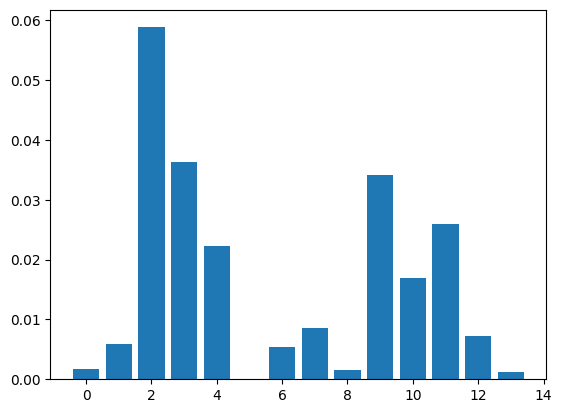

In [230]:
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()

In [231]:
x1 = list(X_traindf.columns)
x1

[('agency_name',),
 ('inspector_name',),
 ('violator_name',),
 ('violation_street_number',),
 ('violation_street_name',),
 ('city',),
 ('state',),
 ('violation_code',),
 ('zip_code',),
 ('mailing_address_str_number',),
 ('disposition',),
 ('mailing_address_str_name',),
 ('violation_description',),
 ('diff',)]

In [232]:
list(fs.scores_)

[0.0017953008410085403,
 0.005866294630289204,
 0.05880618317978126,
 0.036285755577545986,
 0.022195218568204167,
 0.0,
 0.005474282665026919,
 0.00861990652807676,
 0.0015351441315412107,
 0.03407566328447653,
 0.01690051689248251,
 0.025867581876631185,
 0.007196394509779269,
 0.0011779635503164076]

In [233]:
#print(pla)  
idx_list = []
for idx,  pla in enumerate(list(fs.scores_)): 
    if pla < 0.01 :
        idx_list.append(idx)

idx_list

[0, 1, 5, 6, 7, 8, 12, 13]

In [234]:
list(X_traindf.columns)[0][0]

'agency_name'

In [235]:
emp = []
for x,y in enumerate(X_traindf.columns):
    for idx in idx_list:
        if x == idx:
            print(y[0])
            emp.append(y[0])

agency_name
inspector_name
city
state
violation_code
zip_code
violation_description
diff


In [236]:
emp

['agency_name',
 'inspector_name',
 'city',
 'state',
 'violation_code',
 'zip_code',
 'violation_description',
 'diff']

In [237]:
# Find diff in X_test

In [242]:
# load test data
X_test

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,violation_description,disposition,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,grafitti_status
0,284932,Department of Public Works,"Granberry, Aisha B","FLUELLEN, JOHN A",10041.0,ROSEBERRY,NaN,141,ROSEBERRY,DETROIT,...,Failure to secure City or Private solid waste ...,Responsible by Default,200.0,20.0,10.0,20.0,0.0,0.0,250.0,NaN
1,285362,Department of Public Works,"Lusk, Gertrina","WHIGHAM, THELMA",18520.0,EVERGREEN,NaN,19136,GLASTONBURY,DETROIT,...,Allowing bulk solid waste to lie or accumulate...,Responsible by Default,1000.0,20.0,10.0,100.0,0.0,0.0,1130.0,NaN
2,285361,Department of Public Works,"Lusk, Gertrina","WHIGHAM, THELMA",18520.0,EVERGREEN,NaN,19136,GLASTONBURY,DETROIT,...,Improper placement of Courville container betw...,Responsible by Default,100.0,20.0,10.0,10.0,0.0,0.0,140.0,NaN
3,285338,Department of Public Works,"Talbert, Reginald","HARABEDIEN, POPKIN",1835.0,CENTRAL,NaN,2246,NELSON,WOODHAVEN,...,Allowing bulk solid waste to lie or accumulate...,Responsible by Default,200.0,20.0,10.0,20.0,0.0,0.0,250.0,NaN
4,285346,Department of Public Works,"Talbert, Reginald","CORBELL, STANLEY",1700.0,CENTRAL,NaN,3435,MUNGER,LIVONIA,...,Violation of time limit for approved container...,Responsible by Default,100.0,20.0,10.0,10.0,0.0,0.0,140.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60996,376496,"Buildings, Safety Engineering & Env Department","Pierson, Kevin",THE AIC GROUP,12032.0,SANTA ROSA,48204,P.O. BO,969,Southfield,...,Fail to comply with an Emergency or imminent d...,Responsible by Default,1000.0,20.0,10.0,100.0,0.0,0.0,1130.0,NaN
60997,376497,"Buildings, Safety Engineering & Env Department","Pierson, Kevin",THE AIC GROUP,12032.0,SANTA ROSA,48204,P.O. BO,969,Southfield,...,Fail to comply with an Emergency or imminent d...,Responsible by Default,1000.0,20.0,10.0,100.0,0.0,0.0,1130.0,NaN
60998,376499,Detroit Police Department,"BOWLES, TIFFANI","BARLOW, CHRISTOPHER D",11832.0,KILBOURNE,48213,11832,KILBOURNE,DETROIT,...,Violation of time limit for approved container...,Responsible by Default,100.0,20.0,10.0,10.0,0.0,0.0,140.0,NaN
60999,376500,Detroit Police Department,"BOWLES, TIFFANI","WILLIAMS, JASON",11848.0,KILBOURNE,48213,4317,YORKSHIRE,DETROIT,...,Violation of time limit for approved container...,Responsible by Default,100.0,20.0,10.0,10.0,0.0,0.0,140.0,NaN


In [243]:
X_testcopy = X_test
X_testcopy

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,violation_description,disposition,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,grafitti_status
0,284932,Department of Public Works,"Granberry, Aisha B","FLUELLEN, JOHN A",10041.0,ROSEBERRY,NaN,141,ROSEBERRY,DETROIT,...,Failure to secure City or Private solid waste ...,Responsible by Default,200.0,20.0,10.0,20.0,0.0,0.0,250.0,NaN
1,285362,Department of Public Works,"Lusk, Gertrina","WHIGHAM, THELMA",18520.0,EVERGREEN,NaN,19136,GLASTONBURY,DETROIT,...,Allowing bulk solid waste to lie or accumulate...,Responsible by Default,1000.0,20.0,10.0,100.0,0.0,0.0,1130.0,NaN
2,285361,Department of Public Works,"Lusk, Gertrina","WHIGHAM, THELMA",18520.0,EVERGREEN,NaN,19136,GLASTONBURY,DETROIT,...,Improper placement of Courville container betw...,Responsible by Default,100.0,20.0,10.0,10.0,0.0,0.0,140.0,NaN
3,285338,Department of Public Works,"Talbert, Reginald","HARABEDIEN, POPKIN",1835.0,CENTRAL,NaN,2246,NELSON,WOODHAVEN,...,Allowing bulk solid waste to lie or accumulate...,Responsible by Default,200.0,20.0,10.0,20.0,0.0,0.0,250.0,NaN
4,285346,Department of Public Works,"Talbert, Reginald","CORBELL, STANLEY",1700.0,CENTRAL,NaN,3435,MUNGER,LIVONIA,...,Violation of time limit for approved container...,Responsible by Default,100.0,20.0,10.0,10.0,0.0,0.0,140.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60996,376496,"Buildings, Safety Engineering & Env Department","Pierson, Kevin",THE AIC GROUP,12032.0,SANTA ROSA,48204,P.O. BO,969,Southfield,...,Fail to comply with an Emergency or imminent d...,Responsible by Default,1000.0,20.0,10.0,100.0,0.0,0.0,1130.0,NaN
60997,376497,"Buildings, Safety Engineering & Env Department","Pierson, Kevin",THE AIC GROUP,12032.0,SANTA ROSA,48204,P.O. BO,969,Southfield,...,Fail to comply with an Emergency or imminent d...,Responsible by Default,1000.0,20.0,10.0,100.0,0.0,0.0,1130.0,NaN
60998,376499,Detroit Police Department,"BOWLES, TIFFANI","BARLOW, CHRISTOPHER D",11832.0,KILBOURNE,48213,11832,KILBOURNE,DETROIT,...,Violation of time limit for approved container...,Responsible by Default,100.0,20.0,10.0,10.0,0.0,0.0,140.0,NaN
60999,376500,Detroit Police Department,"BOWLES, TIFFANI","WILLIAMS, JASON",11848.0,KILBOURNE,48213,4317,YORKSHIRE,DETROIT,...,Violation of time limit for approved container...,Responsible by Default,100.0,20.0,10.0,10.0,0.0,0.0,140.0,NaN


In [249]:
X_testcopy['hearing_date'][0]

'2012-01-19 09:00:00'

In [250]:
X_testcopy['payment_date'][0]

KeyError: 'payment_date'

In [251]:
X_test.columns

Index(['ticket_id', 'agency_name', 'inspector_name', 'violator_name',
       'violation_street_number', 'violation_street_name',
       'violation_zip_code', 'mailing_address_str_number',
       'mailing_address_str_name', 'city', 'state', 'zip_code',
       'non_us_str_code', 'country', 'ticket_issued_date', 'hearing_date',
       'violation_code', 'violation_description', 'disposition', 'fine_amount',
       'admin_fee', 'state_fee', 'late_fee', 'discount_amount',
       'clean_up_cost', 'judgment_amount', 'grafitti_status'],
      dtype='object')

In [246]:
X_testcopy.hearing_date = X_testcopy['hearing_date'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
X_testcopy.payment_date = X_testcopy['payment_date'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))

TypeError: strptime() argument 1 must be str, not float

In [245]:
X_testcopy['diff'] = X_testcopy.payment_date - X_testcopy.hearing_date

AttributeError: 'DataFrame' object has no attribute 'payment_date'

In [ ]:
X_testcopy['diff'] = X_testcopy['diff'].astype('timedelta64[D]')
X_testcopy['diff'] = X_testcopy['diff'].apply(lambda x: x.dt.days, axis=1)

In [ ]:
# grab only the columns from X_test that you need
X_testrun = X_testcopy[emp]

In [ ]:
from sklearn import linear_model

logr = linear_model.LogisticRegression()
logr.fit(X_testrun,y_train1)

In [ ]:
prob_predict = logr.predict_proba(X_traindf)
prob_predict

In [ ]:
probdf = pd.DataFrame(prob_predict, columns = ['no', 'yes'])
probdf

In [116]:
X_test1 = prepare_inputs(X_test)
X_test1

array([[0.0000e+00, 1.0000e+00, 4.5000e+01, ..., 0.0000e+00, 3.6000e+01,
               nan],
       [3.5000e+01, 1.0000e+00, 6.5000e+01, ..., 0.0000e+00, 2.6700e+02,
               nan],
       [3.4000e+01, 1.0000e+00, 6.5000e+01, ..., 0.0000e+00, 1.6000e+01,
               nan],
       ...,
       [6.0981e+04, 2.0000e+00, 3.0000e+00, ..., 0.0000e+00, 1.6000e+01,
               nan],
       [6.0982e+04, 2.0000e+00, 3.0000e+00, ..., 0.0000e+00, 1.6000e+01,
               nan],
       [5.7009e+04, 1.0000e+00, 5.6000e+01, ..., 0.0000e+00, 6.0000e+00,
               nan]])

In [118]:
X_testdf = pd.DataFrame(X_test1, columns=[X_test.columns])
X_testdf

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,violation_description,disposition,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,grafitti_status
0,0.0,1.0,45.0,12408.0,6765.0,1181.0,NaN,1129.0,11750.0,739.0,...,98.0,5.0,14.0,0.0,0.0,11.0,0.0,0.0,36.0,NaN
1,35.0,1.0,65.0,36291.0,12036.0,471.0,NaN,3477.0,5502.0,739.0,...,0.0,5.0,39.0,0.0,0.0,31.0,0.0,0.0,267.0,NaN
2,34.0,1.0,65.0,36291.0,12036.0,471.0,NaN,3477.0,5502.0,739.0,...,105.0,5.0,9.0,0.0,0.0,7.0,0.0,0.0,16.0,NaN
3,16.0,1.0,99.0,15025.0,1231.0,255.0,NaN,4324.0,9232.0,3040.0,...,0.0,5.0,14.0,0.0,0.0,11.0,0.0,0.0,36.0,NaN
4,23.0,1.0,99.0,7990.0,1148.0,255.0,NaN,5940.0,8517.0,1558.0,...,161.0,5.0,9.0,0.0,0.0,7.0,0.0,0.0,16.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60996,60979.0,0.0,81.0,33900.0,7736.0,1209.0,4.0,9679.0,645.0,2715.0,...,30.0,5.0,39.0,0.0,0.0,31.0,0.0,0.0,267.0,NaN
60997,60980.0,0.0,81.0,33900.0,7736.0,1209.0,4.0,9679.0,645.0,2715.0,...,30.0,5.0,39.0,0.0,0.0,31.0,0.0,0.0,267.0,NaN
60998,60981.0,2.0,3.0,4033.0,7636.0,757.0,13.0,310.0,6951.0,739.0,...,161.0,5.0,9.0,0.0,0.0,7.0,0.0,0.0,16.0,NaN
60999,60982.0,2.0,3.0,36621.0,7648.0,757.0,13.0,6693.0,16190.0,739.0,...,161.0,5.0,9.0,0.0,0.0,7.0,0.0,0.0,16.0,NaN


In [124]:
X_traindf = pd.DataFrame(X_train_enc1, columns=[X_train1.columns])
X_traindf

,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,city,state,violation_code,zip_code,mailing_address_str_number,disposition,mailing_address_str_name,violation_description
0,0.0,125.0,36627.0,2571.0,1566.0,508.0,15.0,142.0,2184.0,2.0,2.0,18905.0,69.0
1,0.0,153.0,54152.0,3899.0,290.0,903.0,23.0,73.0,1537.0,2210.0,3.0,13723.0,47.0
2,0.0,125.0,40941.0,5859.0,1183.0,1850.0,5.0,142.0,2886.0,2062.0,2.0,5983.0,69.0
3,0.0,153.0,21408.0,7085.0,202.0,684.0,23.0,72.0,1351.0,392.0,2.0,8940.0,48.0
4,0.0,153.0,65229.0,7277.0,1148.0,903.0,23.0,71.0,1542.0,5360.0,2.0,13876.0,151.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
157212,1.0,87.0,52436.0,11892.0,1687.0,828.0,23.0,46.0,1587.0,7756.0,2.0,25117.0,0.0
157213,1.0,158.0,46402.0,16848.0,1184.0,828.0,23.0,46.0,1607.0,10267.0,2.0,12712.0,0.0
157214,1.0,9.0,13389.0,6398.0,318.0,828.0,23.0,46.0,1529.0,4771.0,2.0,23230.0,0.0
157215,1.0,62.0,35775.0,14753.0,1148.0,828.0,23.0,31.0,1544.0,1330.0,3.0,13560.0,126.0


In [177]:
# Grab columns 1,4,5,8
#X_traindf1 = X_traindf.iloc[:,[3,4,7,12]]
#X_traindf1

In [179]:
X_testdf1 = X_testdf[X_traindf.columns]
X_testdf1

,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,city,state,violation_code,zip_code,mailing_address_str_number,disposition,mailing_address_str_name,violation_description
0,1.0,45.0,12408.0,6765.0,1181.0,739.0,23.0,31.0,1316.0,1129.0,5.0,11750.0,98.0
1,1.0,65.0,36291.0,12036.0,471.0,739.0,23.0,48.0,1330.0,3477.0,5.0,5502.0,0.0
2,1.0,65.0,36291.0,12036.0,471.0,739.0,23.0,19.0,1330.0,3477.0,5.0,5502.0,105.0
3,1.0,99.0,15025.0,1231.0,255.0,3040.0,23.0,48.0,1255.0,4324.0,5.0,9232.0,0.0
4,1.0,99.0,7990.0,1148.0,255.0,1558.0,23.0,21.0,1232.0,5940.0,5.0,8517.0,161.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
60996,0.0,81.0,33900.0,7736.0,1209.0,2715.0,23.0,132.0,1121.0,9679.0,5.0,645.0,30.0
60997,0.0,81.0,33900.0,7736.0,1209.0,2715.0,23.0,132.0,1121.0,9679.0,5.0,645.0,30.0
60998,2.0,3.0,4033.0,7636.0,757.0,739.0,23.0,21.0,1316.0,310.0,5.0,6951.0,161.0
60999,2.0,3.0,36621.0,7648.0,757.0,739.0,23.0,21.0,1343.0,6693.0,5.0,16190.0,161.0


In [184]:
len(X_testdf1.columns)

13

In [190]:
for i in X_testdf1.columns:
    X_testdf1[i] = X_testdf1[i].replace(np.nan, 0)
X_testdf1

/var/folders/96/6jf045t109g4mzwn7_3s3lz80000gn/T/ipykernel_37801/1599613098.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_testdf1[i] = X_testdf1[i].replace(np.nan, 0)


,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,city,state,violation_code,zip_code,mailing_address_str_number,disposition,mailing_address_str_name,violation_description
0,1.0,45.0,12408.0,6765.0,1181.0,739.0,23.0,31.0,1316.0,1129.0,5.0,11750.0,98.0
1,1.0,65.0,36291.0,12036.0,471.0,739.0,23.0,48.0,1330.0,3477.0,5.0,5502.0,0.0
2,1.0,65.0,36291.0,12036.0,471.0,739.0,23.0,19.0,1330.0,3477.0,5.0,5502.0,105.0
3,1.0,99.0,15025.0,1231.0,255.0,3040.0,23.0,48.0,1255.0,4324.0,5.0,9232.0,0.0
4,1.0,99.0,7990.0,1148.0,255.0,1558.0,23.0,21.0,1232.0,5940.0,5.0,8517.0,161.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
60996,0.0,81.0,33900.0,7736.0,1209.0,2715.0,23.0,132.0,1121.0,9679.0,5.0,645.0,30.0
60997,0.0,81.0,33900.0,7736.0,1209.0,2715.0,23.0,132.0,1121.0,9679.0,5.0,645.0,30.0
60998,2.0,3.0,4033.0,7636.0,757.0,739.0,23.0,21.0,1316.0,310.0,5.0,6951.0,161.0
60999,2.0,3.0,36621.0,7648.0,757.0,739.0,23.0,21.0,1343.0,6693.0,5.0,16190.0,161.0


In [191]:
from sklearn import linear_model

logr = linear_model.LogisticRegression()
logr.fit(X_traindf,y_train1)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [192]:
prob_predict = logr.predict_proba(X_testdf1)
prob_predict

array([[0.82652759, 0.17347241],
       [0.87992232, 0.12007768],
       [0.84831319, 0.15168681],
       ...,
       [0.79025005, 0.20974995],
       [0.83557619, 0.16442381],
       [0.88974123, 0.11025877]])

In [193]:
probdf = pd.DataFrame(prob_predict, columns = ['no', 'yes'])
probdf

,no,yes
0,0.826528,0.173472
1,0.879922,0.120078
2,0.848313,0.151687
3,0.865054,0.134946
4,0.807841,0.192159
...,...,...
60996,0.919635,0.080365
60997,0.919635,0.080365
60998,0.790250,0.209750
60999,0.835576,0.164424


In [194]:
probno = probdf['no']
probno

0        0.826528
1        0.879922
2        0.848313
3        0.865054
4        0.807841
           ...   
60996    0.919635
60997    0.919635
60998    0.790250
60999    0.835576
61000    0.889741
Name: no, Length: 61001, dtype: float64

In [195]:
probyes = probdf['yes']
probyes

0        0.173472
1        0.120078
2        0.151687
3        0.134946
4        0.192159
           ...   
60996    0.080365
60997    0.080365
60998    0.209750
60999    0.164424
61000    0.110259
Name: yes, Length: 61001, dtype: float64

In [196]:
predict_array = np.empty([61001])
len(predict_array)

61001

In [197]:
num = 0
zero = 0
one = 0
for i in probno:
    if i > probyes[num]:
        predict_array[num] = 0
        zero += 1
    else:
        predict_array[num] = 1
        one += 1
    num += 1
probyes[38500]

0.2048321302798341

In [198]:
zero

61001

In [199]:
for i in predict_array:
    if i == 0:
        print(i)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [200]:
#@title Make function to define y_predict below

# X_test / Xout2

def find_y_val(probdf) :
    '''
    :arg1  prob_predict numpy array : This show array
    containing probs of "0" and "1"    
     coding instruction 
     1. find max value in each row
     2. depending on max value, assign 0 or 1 accordigly 
     : predict_array : 0 or 1
     : prob_arry : probability of 1  '''
    
    predict_array = np.empty([61001])
    prob_array = probdf['yes']
    
    probno = probdf['no']
    probyes = probdf['yes']
    
    num = 0
    for i in probno:
        if i > probyes[num]:
            predict_array[num] = 0
        else:
            predict_array[num] = 1
        num += 1
            
    
    return (predict_array, prob_array)

predict_array, prob_array = find_y_val(probdf)

In [173]:
predict_array

array([0., 0., 0., ..., 0., 0., 0.])

In [158]:
prob_array

0        0.151185
1        0.171777
2        0.155262
3        0.327079
4        0.251129
           ...   
60996    0.067244
60997    0.067244
60998    0.146633
60999    0.146527
61000    0.153601
Name: yes, Length: 61001, dtype: float64

In [159]:
X_test.ticket_id

0        284932
1        285362
2        285361
3        285338
4        285346
          ...  
60996    376496
60997    376497
60998    376499
60999    376500
61000    369851
Name: ticket_id, Length: 61001, dtype: int64

# Answer

In [160]:
ans = np.vstack((X_test.ticket_id, prob_array)).T
ans

array([[2.84932000e+05, 1.51185358e-01],
       [2.85362000e+05, 1.71776966e-01],
       [2.85361000e+05, 1.55261666e-01],
       ...,
       [3.76499000e+05, 1.46633031e-01],
       [3.76500000e+05, 1.46527387e-01],
       [3.69851000e+05, 1.53601295e-01]])

In [959]:
logr.predict(Xout2) == predict_array

# if the result is True -> Correct
# if the rsult if False -> Incorrect function

array([ True,  True,  True, ...,  True,  True,  True])

In [788]:
logr.predict(Xout2)

array([0, 0, 0, ..., 0, 0, 0])

In [771]:
import numpy

def logit2prob(logr, Xfinal2):
    logprob = logr.coef_ * Xfinal2 + logr.intercept_
    odds = numpy.exp(logprob)
    probability = odds / (1 + odds)
    return(probability)

poss = logit2prob(logr, Xfinal2)

ValueError: Unable to coerce to Series, length must be 7: given 1

In [751]:
ans = pd.DataFrame(X_test['ticket_id'])
ans['percentage'] = poss

In [752]:
ans

,ticket_id,percentage
0,284932,0.067716
1,285362,0.067716
2,285361,0.067716
3,285338,0.067716
4,285346,0.067716
...,...,...
60996,376496,0.067716
60997,376497,0.067716
60998,376499,0.067716
60999,376500,0.067716


In [825]:
def blight_model(input1, input2):
    
    # Your code here
    
    ans1 = np.vstack((input1, input2)).T
    
    
    
    return ans1 # Your answer 
blight_model(X_test.ticket_id, prob_array)

array([[2.84932000e+05, 1.39693031e-01],
       [2.85362000e+05, 9.94862465e-02],
       [2.85361000e+05, 1.27548579e-01],
       ...,
       [3.76499000e+05, 1.15066836e-01],
       [3.76500000e+05, 1.15012140e-01],
       [3.69851000e+05, 1.01491698e-01]])

In [755]:
for i in ans:
    print(i)

ticket_id
percentage


In [479]:
reg.score(X_test_enc, array1)

1.0

In [467]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(X_train_enc, y_train_enc)

model.score(X_train_enc, y_train_enc)

0.08824283081475592

In [468]:
X_train_enc
X_train_pre = pd.DataFrame(X_train_enc, columns=listenc)
X_train_pre

,inspector_name,violation_street_number,violation_street_name,city,violation_code,violation_description,disposition,admin_fee,state_fee,discount_amount,judgment_amount
0,125.0,2573.0,1571.0,543.0,143.0,69.0,2.0,0.0,0.0,0.0,21.0
1,153.0,3903.0,290.0,952.0,74.0,47.0,3.0,0.0,0.0,0.0,35.0
2,125.0,5864.0,1186.0,1930.0,143.0,69.0,2.0,0.0,0.0,0.0,21.0
3,153.0,7090.0,202.0,725.0,73.0,48.0,2.0,0.0,0.0,0.0,35.0
4,153.0,7282.0,1151.0,952.0,72.0,152.0,2.0,0.0,0.0,0.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...
159875,158.0,16876.0,1187.0,873.0,47.0,0.0,2.0,0.0,0.0,0.0,17.0
159876,75.0,13526.0,1495.0,873.0,47.0,0.0,2.0,0.0,0.0,0.0,39.0
159877,9.0,6403.0,318.0,873.0,47.0,0.0,2.0,0.0,0.0,0.0,30.0
159878,62.0,14775.0,1151.0,873.0,32.0,127.0,3.0,0.0,0.0,0.0,16.0


In [469]:
X_test_enc
X_test_pre = pd.DataFrame(X_test_enc, columns=listenc)
X_test_pre

,inspector_name,violation_street_number,violation_street_name,city,violation_code,violation_description,disposition,admin_fee,state_fee,discount_amount,judgment_amount
0,45.0,6765.0,1181.0,739.0,31.0,98.0,-1.0,0.0,0.0,0.0,36.0
1,65.0,12036.0,471.0,739.0,48.0,0.0,-1.0,0.0,0.0,0.0,-1.0
2,65.0,12036.0,471.0,739.0,19.0,105.0,-1.0,0.0,0.0,0.0,16.0
3,99.0,1231.0,255.0,3040.0,48.0,0.0,-1.0,0.0,0.0,0.0,36.0
4,99.0,1148.0,255.0,1558.0,21.0,161.0,-1.0,0.0,0.0,0.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...
60996,81.0,7736.0,1209.0,2715.0,132.0,30.0,-1.0,0.0,0.0,0.0,-1.0
60997,81.0,7736.0,1209.0,2715.0,132.0,30.0,-1.0,0.0,0.0,0.0,-1.0
60998,3.0,7636.0,757.0,739.0,21.0,161.0,-1.0,0.0,0.0,0.0,16.0
60999,3.0,7648.0,757.0,739.0,21.0,161.0,-1.0,0.0,0.0,0.0,16.0


In [470]:
X_train_final = X_train_pre[['violation_description', 'judgment_amount']]
X_train_final

,violation_description,judgment_amount
0,69.0,21.0
1,47.0,35.0
2,69.0,21.0
3,48.0,35.0
4,152.0,9.0
...,...,...
159875,0.0,17.0
159876,0.0,39.0
159877,0.0,30.0
159878,127.0,16.0


In [471]:
X_test_final = X_test_pre[['violation_description', 'judgment_amount']]
X_test_final

,violation_description,judgment_amount
0,98.0,36.0
1,0.0,-1.0
2,105.0,16.0
3,0.0,36.0
4,161.0,16.0
...,...,...
60996,30.0,-1.0
60997,30.0,-1.0
60998,161.0,16.0
60999,161.0,16.0


In [476]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
'''logit_roc_auc = roc_auc_score(array1, logreg.predict(X_test_final))
fpr, tpr, thresholds = roc_curve(array1, logreg.predict_proba(X_test_final)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()'''
y_pred_proba = logreg.predict_proba(X_test_final)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


ValueError: X has 2 features, but LogisticRegression is expecting 11 features as input.

In [ ]:
def blight_model():
    
    # Your code here
    
    
    return # Your answer here

In [ ]:
blight_model()